In [100]:
import warnings
warnings.filterwarnings('ignore')

## Import Libraries

In [101]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

## Loading Data

In [102]:
df = pd.read_csv("alzheimers_disease_data.csv", index_col=0)

In [103]:
display(df.head())

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
PatientID,,,,,,,,,,,,,,,,,,,,,
4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


In [104]:
# drop the column for doctor in charge
df = df.drop(df.columns[-1], axis=1)

In [105]:
df.shape

(2149, 33)

In [106]:
# Checking type of features
df.dtypes

Age                            int64
Gender                         int64
Ethnicity                      int64
EducationLevel                 int64
BMI                          float64
Smoking                        int64
AlcoholConsumption           float64
PhysicalActivity             float64
DietQuality                  float64
SleepQuality                 float64
FamilyHistoryAlzheimers        int64
CardiovascularDisease          int64
Diabetes                       int64
Depression                     int64
HeadInjury                     int64
Hypertension                   int64
SystolicBP                     int64
DiastolicBP                    int64
CholesterolTotal             float64
CholesterolLDL               float64
CholesterolHDL               float64
CholesterolTriglycerides     float64
MMSE                         float64
FunctionalAssessment         float64
MemoryComplaints               int64
BehavioralProblems             int64
ADL                          float64
C

In [107]:
# Check for null values
columns_with_null = df.columns[df.isnull().any()]
print("Columns with null values:", list(columns_with_null))

Columns with null values: []


In [108]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# import missingno as msno
# msno.matrix(df)
# plt.show()

# df.fillna(df.mean(), inplace=True)
# df.fillna(df.median(), inplace=True)  

Missing values in each column:
Age                          0
Gender                       0
Ethnicity                    0
EducationLevel               0
BMI                          0
Smoking                      0
AlcoholConsumption           0
PhysicalActivity             0
DietQuality                  0
SleepQuality                 0
FamilyHistoryAlzheimers      0
CardiovascularDisease        0
Diabetes                     0
Depression                   0
HeadInjury                   0
Hypertension                 0
SystolicBP                   0
DiastolicBP                  0
CholesterolTotal             0
CholesterolLDL               0
CholesterolHDL               0
CholesterolTriglycerides     0
MMSE                         0
FunctionalAssessment         0
MemoryComplaints             0
BehavioralProblems           0
ADL                          0
Confusion                    0
Disorientation               0
PersonalityChanges           0
DifficultyCompletingTasks    0
Forgetfu

### Heatmap

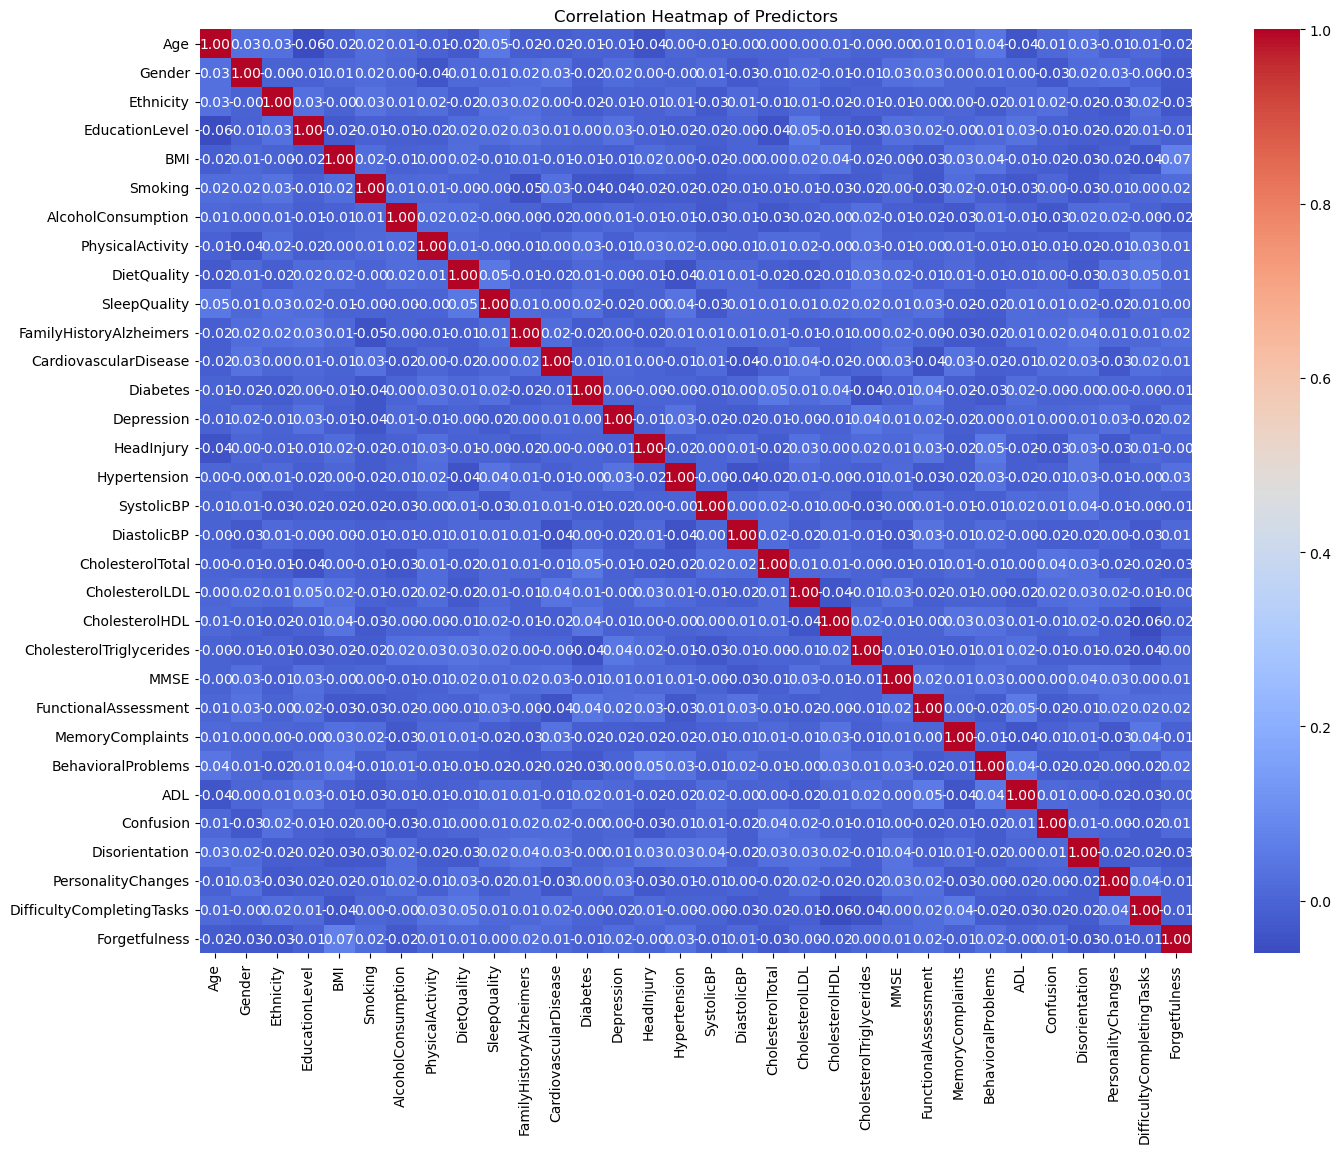

In [109]:
# Exclude target variable
predictors = df.drop(columns=['Diagnosis'])

# Compute correlation matrix
corr_matrix = predictors.corr()

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Predictors")
plt.savefig("heatmap.jpg")
plt.show()


In [110]:
# This correction resolves the error below in visualization.
# Also since we want to keep the original data in EDA, we will not override `df` but use `scaled_df` in the models.
# -GT

# Scaling numerical features
from sklearn.preprocessing import StandardScaler

# Identifying numeric columns
# numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns  # This incorrectly select all columns including categorical
numeric_columns = list(df.select_dtypes('float64').columns) + ['Age', 'SystolicBP', 'DiastolicBP']
scaler = StandardScaler()
scaled_df = df.copy()
scaled_df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

No highly correlated variables.

In [ ]:
X = scaled_df.drop(columns=['Diagnosis'])  # Predictors
y = scaled_df['Diagnosis']  # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the models
models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),  # Scaling is important for LR
        ('model', LogisticRegression())
    ]),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier()
}

# Train and evaluate each model
results = {}
for model_name, pipeline in models.items():
    pipeline.fit(X_train, y_train)  # Train the model
    y_pred = pipeline.predict(X_test)  # Predict on test data
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    results[model_name] = accuracy
    
    # Print classification report
    print(f"Model: {model_name}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

# Print overall results
print("Summary of Model Accuracies:")
for model, accuracy in results.items():
    print(f"{model}: {accuracy:.4f}")

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       278
           1       0.74      0.74      0.74       152

    accuracy                           0.82       430
   macro avg       0.80      0.80      0.80       430
weighted avg       0.82      0.82      0.82       430

--------------------------------------------------
Model: Decision Tree
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       278
           1       0.83      0.84      0.83       152

    accuracy                           0.88       430
   macro avg       0.87      0.87      0.87       430
weighted avg       0.88      0.88      0.88       430

--------------------------------------------------
Model: XGBoost
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       278
           1       0.94      0.89      0.92       152

    accuracy     

In [ ]:
# Check the coefficients of the logistic regression model

important_feat = sorted(zip(
    models['Logistic Regression'].named_steps['model'].coef_[0],
    X.columns
), key=lambda t: abs(t[0]), reverse=True)
important_feat[:7]

[(-1.318723376086754, 'FunctionalAssessment'),
 (-1.2709133390638256, 'ADL'),
 (1.1372174158660078, 'MemoryComplaints'),
 (0.9280851834718691, 'BehavioralProblems'),
 (-0.8597950013014275, 'MMSE'),
 (0.1502186938932409, 'CholesterolHDL'),
 (-0.14995501583299645, 'CholesterolLDL')]

In [174]:
# Check the feature importance of the decision tree model

important_feat = sorted(zip(
    models['Decision Tree'].feature_importances_,
    X.columns
), reverse=True)
important_feat[:7]

[(0.23578326438662128, 'MMSE'),
 (0.20147961435244321, 'ADL'),
 (0.1840174699393951, 'FunctionalAssessment'),
 (0.14148417484358478, 'MemoryComplaints'),
 (0.0989249920239703, 'BehavioralProblems'),
 (0.01764004746029236, 'DietQuality'),
 (0.01720959039409468, 'SystolicBP')]

We notice that the five Cognitive and Functional Assessment features contribute the most to our model, significantly surpassing all other features. This suggests that the final diagnosis may be directly derived from the results of these assessments.

Applying Feature selection before splitting

In [112]:
from sklearn.feature_selection import SelectKBest, f_classif

# Define predictors (X) and target (y)
X = scaled_df.drop(columns=['Diagnosis'])  # Predictors
y = scaled_df['Diagnosis']  # Target

# Feature Selection
# Select the top k features based on ANOVA F-value
k = 10  # Choose the number of features to retain (adjust based on experimentation)
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print(f"Selected features: {selected_features}")

# Check and convert target to discrete classes if necessary
print("Before processing, unique values in y:", y.unique())

# Example: Binarize continuous target (adjust the threshold as needed)
threshold = 0.5  # Modify based on your problem domain
if y.dtypes in ['float64', 'float32']:  # Check if y is continuous
    y = (y > threshold).astype(int)

print("After processing, unique values in y:", y.unique())

# Proceed with feature selection and train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

Selected features: Index(['EducationLevel', 'SleepQuality', 'FamilyHistoryAlzheimers',
       'Hypertension', 'CholesterolHDL', 'MMSE', 'FunctionalAssessment',
       'MemoryComplaints', 'BehavioralProblems', 'ADL'],
      dtype='object')
Before processing, unique values in y: [0 1]
After processing, unique values in y: [0 1]


In [128]:
# Define the models
models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),  # Scaling is important for LR
        ('model', LogisticRegression())
    ]),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier()
}

# Train and evaluate each model
results = {}
for model_name, pipeline in models.items():
    pipeline.fit(X_train, y_train) 
    y_pred = pipeline.predict(X_test)  
    accuracy = accuracy_score(y_test, y_pred) 
    results[model_name] = accuracy
    
    # Print classification report
    print(f"Model: {model_name}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

print("Summary of Model Accuracies:")
for model, accuracy in results.items():
    print(f"{model}: {accuracy:.4f}")

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       278
           1       0.76      0.61      0.68       152

    accuracy                           0.80       430
   macro avg       0.79      0.75      0.76       430
weighted avg       0.79      0.80      0.79       430

--------------------------------------------------
Model: Decision Tree
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       278
           1       0.66      0.65      0.66       152

    accuracy                           0.76       430
   macro avg       0.74      0.74      0.74       430
weighted avg       0.76      0.76      0.76       430

--------------------------------------------------
Model: XGBoost
              precision    recall  f1-score   support

           0       0.83      0.88      0.86       278
           1       0.76      0.67      0.71       152

    accuracy     

Predictions based on Feature Categories

In [129]:
# Define feature categories
categories = {
    "Demographic": ['EducationLevel', 'FamilyHistoryAlzheimers'],
    "Lifestyle": ['SleepQuality', 'MemoryComplaints'],
    "Medical": ['Hypertension', 'CholesterolHDL', 'BehavioralProblems'],
    "Cognitive": ['MMSE', 'FunctionalAssessment', 'ADL']
}

# Iterate through each category, subset the data, and run the models
results_by_category = {}

for category, features in categories.items():
    print(f"\n### Predictions based on {category} features ###")
    
    # Subset the data
    X_category = scaled_df[features]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_category, y, test_size=0.2, random_state=42, stratify=y)
    
    # Train and evaluate models
    results = {}
    for model_name, pipeline in models.items():
        pipeline.fit(X_train, y_train)  # Train the model
        y_pred = pipeline.predict(X_test)  # Predict on test data
        accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
        results[model_name] = accuracy

        # Print classification report
        print(f"Model: {model_name}")
        print(classification_report(y_test, y_pred))
        print("-" * 50)
    
    # Store results for this category
    results_by_category[category] = results

# Print overall results for each category
print("Summary of Model Accuracies by Feature Category:")
for category, result in results_by_category.items():
    print(f"\n{category}:")
    for model, accuracy in result.items():
        print(f"{model}: {accuracy:.4f}")


### Predictions based on Demographic features ###
Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       278
           1       0.00      0.00      0.00       152

    accuracy                           0.65       430
   macro avg       0.32      0.50      0.39       430
weighted avg       0.42      0.65      0.51       430

--------------------------------------------------
Model: Decision Tree
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       278
           1       0.00      0.00      0.00       152

    accuracy                           0.65       430
   macro avg       0.32      0.50      0.39       430
weighted avg       0.42      0.65      0.51       430

--------------------------------------------------
Model: XGBoost
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       278
           1       0.

Visualize Model Accuracies

             Logistic Regression  Decision Tree   XGBoost  Random Forest
Demographic             0.646512       0.646512  0.646512       0.646512
Lifestyle               0.679070       0.593023  0.655814       0.593023
Medical                 0.693023       0.572093  0.644186       0.576744
Cognitive               0.795349       0.765116  0.809302       0.832558


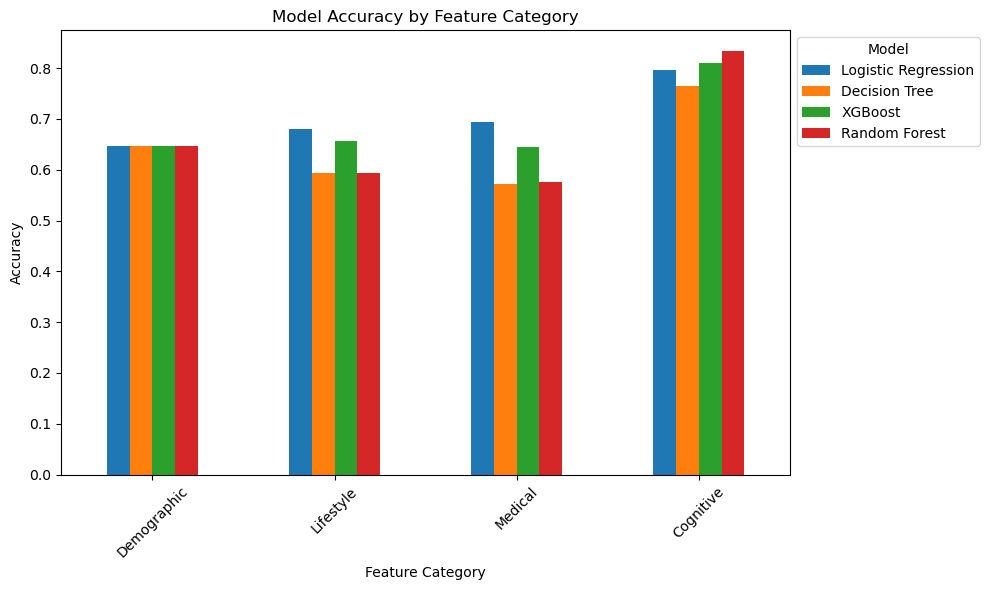

In [130]:
import pandas as pd

# converting results to a DataFrame for easy visualization
# .T - # Transpose for better readability
results_df = pd.DataFrame(results_by_category).T  
print(results_df)

# bar chart
results_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Accuracy by Feature Category")
plt.ylabel("Accuracy")
plt.xlabel("Feature Category")
plt.xticks(rotation=45)
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  
plt.show()

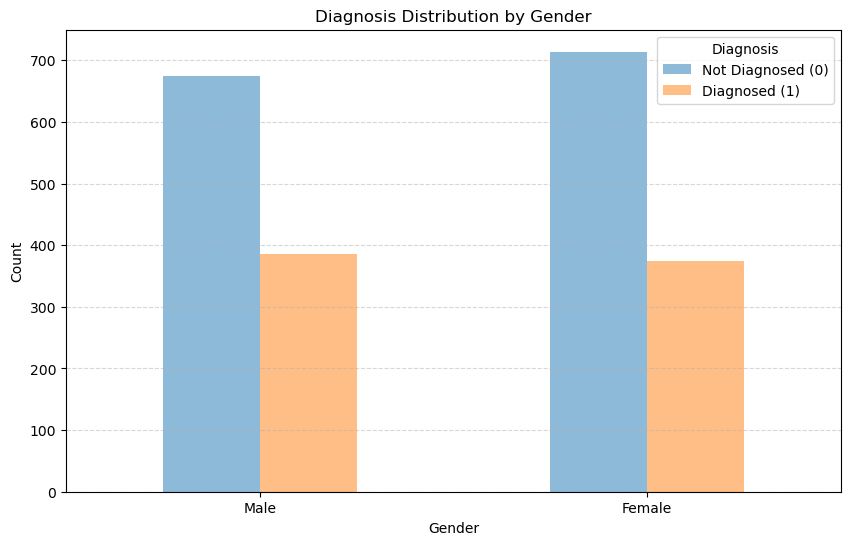

In [131]:
# Plot the count of diagnoses split by gender
gender_diagnosis_counts = df.groupby(['Gender', 'Diagnosis']).size().unstack(fill_value=0)
ax = gender_diagnosis_counts.plot(kind='bar', figsize=(10, 6), alpha=0.5)

plt.title('Diagnosis Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
ax.set_xticklabels(['Male', 'Female'])
plt.xticks(rotation=0)
plt.legend(title='Diagnosis', labels=['Not Diagnosed (0)', 'Diagnosed (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

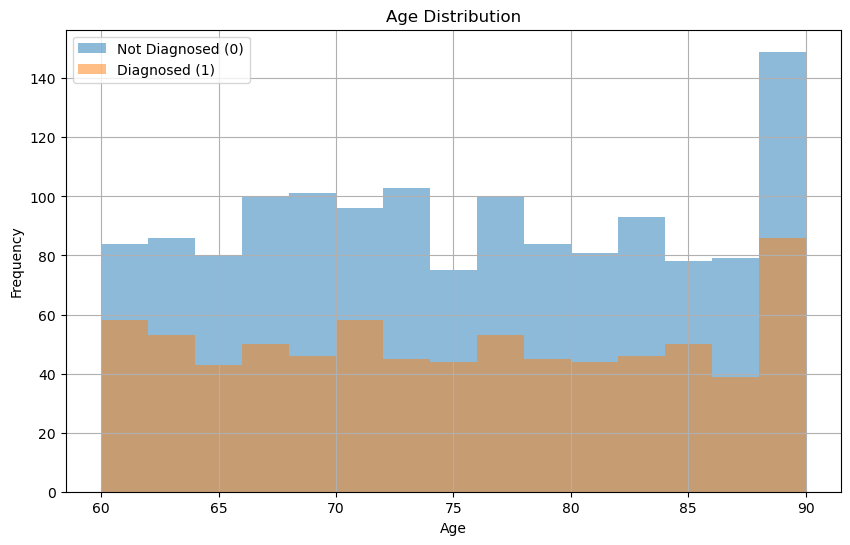

In [132]:
# Histograms for Age, split by Diagnosis
diagnosis_labels = {0: 'Not Diagnosed (0)', 1: 'Diagnosed (1)'}
plt.figure(figsize=(10, 6))
for diagnosis, group in df.groupby('Diagnosis'):
    plt.hist(group['Age'], bins=15, alpha=0.5, label=diagnosis_labels[diagnosis])

plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Generating this error: 
# ---------------------------------------------------------------------------
# KeyError                                  Traceback (most recent call last)
# Cell In[75], line 5
#       3 plt.figure(figsize=(10, 6))
#       4 for diagnosis, group in df.groupby('Diagnosis'):
# ----> 5     plt.hist(group['Age'], bins=15, alpha=0.5, label=diagnosis_labels[diagnosis])
#       7 plt.title('Age Distribution')
#       8 plt.xlabel('Age')

# KeyError: -0.7397000929442957
# <Figure size 1000x600 with 0 Axes>


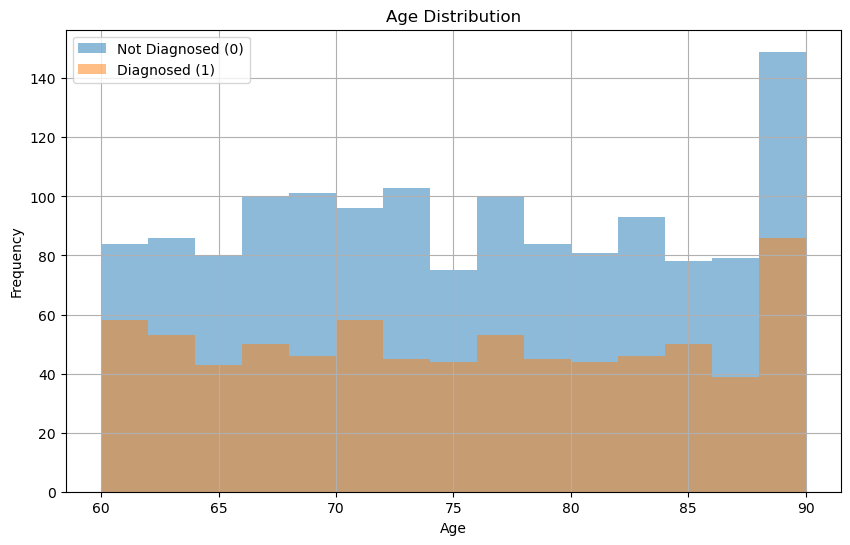

In [133]:
import matplotlib.pyplot as plt

diagnosis_labels = {0: 'Not Diagnosed (0)', 1: 'Diagnosed (1)'}

# Create a figure for plotting
plt.figure(figsize=(10, 6))

# Loop through each diagnosis group to plot histograms
for diagnosis, group in df.groupby('Diagnosis'):
    plt.hist(group['Age'], bins=15, alpha=0.5, label=diagnosis_labels.get(diagnosis, f"Unknown ({diagnosis})"))

# Set the plot labels and title
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

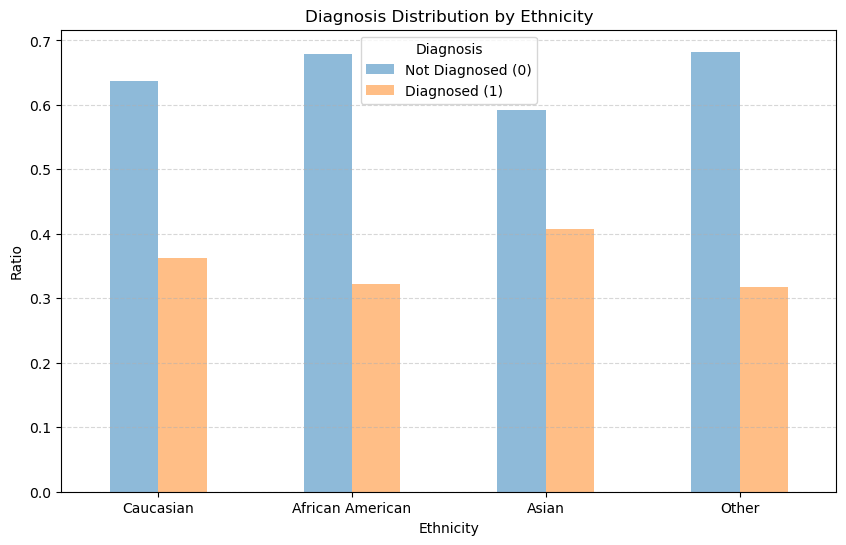

In [134]:
# Plot the ratio of diagnoses split by ethnicity
gender_diagnosis_counts = df.groupby(['Ethnicity', 'Diagnosis']).size().unstack(fill_value=0)
gender_diagnosis_ratio = gender_diagnosis_counts.divide(gender_diagnosis_counts.sum(axis=1), axis=0)
ax = gender_diagnosis_ratio.plot(kind='bar', figsize=(10, 6), alpha=0.5)

plt.title('Diagnosis Distribution by Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Ratio')
ax.set_xticklabels(['Caucasian', 'African American', 'Asian', 'Other'])
plt.xticks(rotation=0)
plt.legend(title='Diagnosis', labels=['Not Diagnosed (0)', 'Diagnosed (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

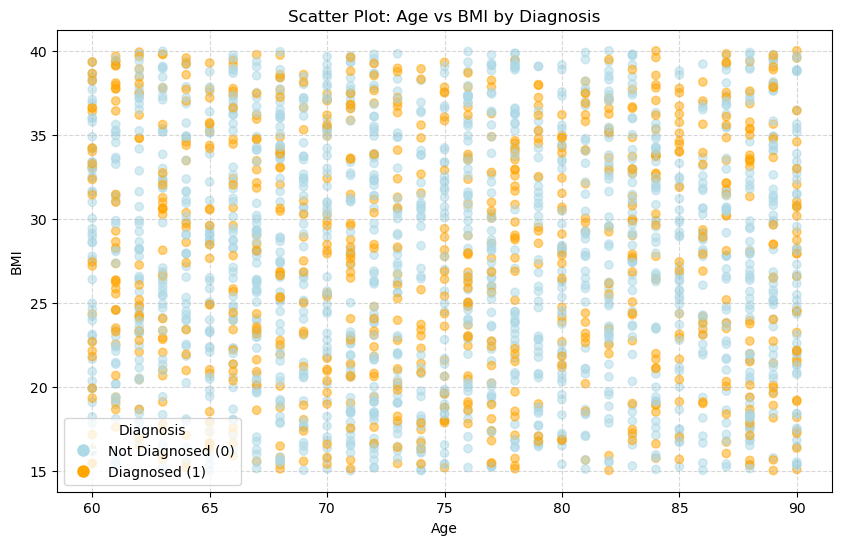

In [135]:
# Scatter plot for Age vs. BMI with Diagnosis as color
import matplotlib.lines as mlines

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df['Age'], 
    df['BMI'], 
    c=['lightblue' if diag == 0 else 'orange' for diag in df['Diagnosis']],
    alpha=0.5,
)

legend_labels = [mlines.Line2D([], [], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label='Not Diagnosed (0)'),
                 mlines.Line2D([], [], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Diagnosed (1)')]
plt.legend(handles=legend_labels, title='Diagnosis')

# Adding color bar and labels
plt.title('Scatter Plot: Age vs BMI by Diagnosis')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

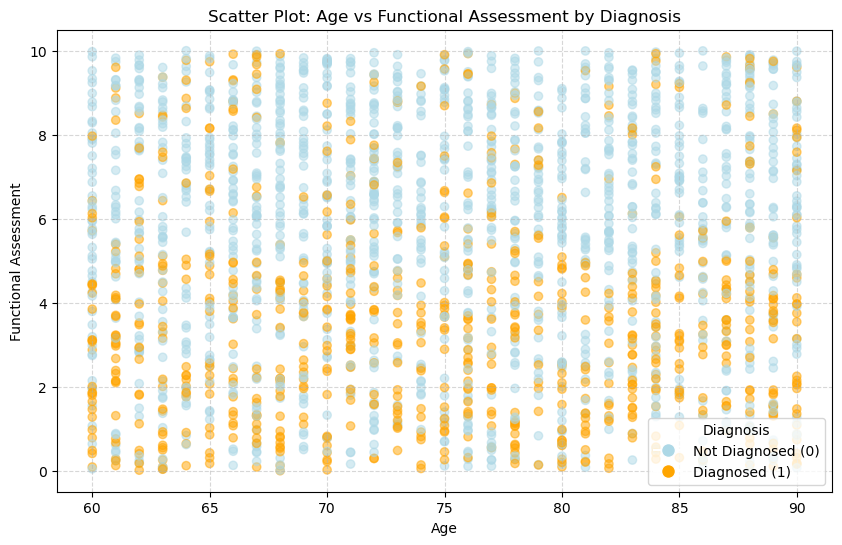

In [136]:
# Scatter plot for Age vs. Functional Assessment with Diagnosis as color
import matplotlib.lines as mlines

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df['Age'], 
    df['FunctionalAssessment'], 
    c=['lightblue' if diag == 0 else 'orange' for diag in df['Diagnosis']],
    alpha=0.5,
)

legend_labels = [mlines.Line2D([], [], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label='Not Diagnosed (0)'),
                 mlines.Line2D([], [], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Diagnosed (1)')]
plt.legend(handles=legend_labels, title='Diagnosis')

# Adding color bar and labels
plt.title('Scatter Plot: Age vs Functional Assessment by Diagnosis')
plt.xlabel('Age')
plt.ylabel('Functional Assessment')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Models for specific (ethnicity, gender, ...) groups
After splitting the dataset, we can train different models for a certain ethnicity, gender, or their combination.

In [177]:
Caucasian = scaled_df[scaled_df['Ethnicity']==0]

In [178]:
X = Caucasian.drop(columns=['Diagnosis'])  # Predictors
y = Caucasian['Diagnosis']  # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the models
models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),  # Scaling is important for LR
        ('model', LogisticRegression())
    ]),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier()
}

# Train and evaluate each model
results = {}
for model_name, pipeline in models.items():
    pipeline.fit(X_train, y_train)  # Train the model
    y_pred = pipeline.predict(X_test)  # Predict on test data
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    results[model_name] = accuracy
    
    # Print classification report
    print(f"Model: {model_name}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

# Print overall results
print("Summary of Model Accuracies:")
for model, accuracy in results.items():
    print(f"{model}: {accuracy:.4f}")

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       163
           1       0.82      0.72      0.77        93

    accuracy                           0.84       256
   macro avg       0.83      0.81      0.82       256
weighted avg       0.84      0.84      0.84       256

--------------------------------------------------
Model: Decision Tree
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       163
           1       0.91      0.92      0.91        93

    accuracy                           0.94       256
   macro avg       0.93      0.93      0.93       256
weighted avg       0.94      0.94      0.94       256

--------------------------------------------------
Model: XGBoost
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       163
           1       0.97      0.91      0.94        93

    accuracy     

In [181]:
# Check the coefficients of the logistic regression model

important_feat = sorted(zip(
    models['Logistic Regression'].named_steps['model'].coef_[0],
    X.columns
), key=lambda t: abs(t[0]), reverse=True)
important_feat[:7]



[(-1.2334585653388686, 'ADL'),
 (-1.23028250777659, 'FunctionalAssessment'),
 (0.9418640157751923, 'MemoryComplaints'),
 (0.9246011429306848, 'BehavioralProblems'),
 (-0.9210974702359519, 'MMSE'),
 (-0.19155309330906087, 'CholesterolLDL'),
 (-0.17832684143293265, 'Age')]

In [180]:
# Check the feature importance of the decision tree model

important_feat = sorted(zip(
    models['Decision Tree'].feature_importances_,
    X.columns
), reverse=True)
important_feat[:7]

[(0.21168646454574414, 'ADL'),
 (0.21105400965326748, 'MMSE'),
 (0.19706845691942268, 'FunctionalAssessment'),
 (0.12093745247252197, 'BehavioralProblems'),
 (0.1209132927643067, 'MemoryComplaints'),
 (0.02235043110269488, 'AlcoholConsumption'),
 (0.01877521307707466, 'CholesterolTriglycerides')]

In [ ]:
# Here is a problem.
# We know the five most important variables now, but we cannot compare within them since the models don't agree to each other.
# Regardless of this, I chose to stick with logistic regression. Here are the results:
# For Male, Asian, and Other Ethnicity, Functional Assessment is recommended;
# For Female, Caucasian, and African American, ADL is recommended.
# Now you might guess Functional Assessment will be recommended for Asian Male, but indeed the most significant factor is MemoryComplaints.
# Yeah.

In [ ]:
Group = scaled_df[(scaled_df['Gender']==0) & (scaled_df['Ethnicity']==2)]  # You can play around with this
X = Group.drop(columns=['Diagnosis'])  # Predictors
y = Group['Diagnosis']  # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the models
models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),  # Scaling is important for LR
        ('model', LogisticRegression())
    ]),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier()
}

# Train and evaluate each model
results = {}
for model_name, pipeline in models.items():
    pipeline.fit(X_train, y_train)  # Train the model
    y_pred = pipeline.predict(X_test)  # Predict on test data
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    results[model_name] = accuracy

# Check the coefficients of the logistic regression model

important_feat = sorted(zip(
    models['Logistic Regression'].named_steps['model'].coef_[0],
    X.columns
), key=lambda t: abs(t[0]), reverse=True)
important_feat[:7]

[(1.600946818465104, 'MemoryComplaints'),
 (-1.363813129756993, 'FunctionalAssessment'),
 (-0.7769816271753653, 'ADL'),
 (-0.7455700858008367, 'MMSE'),
 (-0.6931081442678425, 'Confusion'),
 (0.6400715459970172, 'DietQuality'),
 (0.6020380823691417, 'Disorientation')]